# Лекция №9. Прогнозирование на основе регрессионной модели.

Перед проведением прогнозирования с помощью методов линейной регрессии предлагается ответить на 4 вопроса:  
- 1. Есть ли тренд у временного ряда, и, если есть, то какой?  
- 2. Есть ли сезонность у временного ряда, и, если есть, то какая: аддитивная или мультипликативная?  
- 3. Меняет ли ряд свой характер?  
- 4. Присутствуют ли выбросы?

1. Позволяет изначально предположить более точную модель для прогнозирование (например, степень многочлена);

2. **Сезонность** - повторяющиеся циклические изменения в данных.  
**Аддитивная сезонность**: к тренду (и к модели) просто прибавляем поправку для сезона, т.е. поправка не зависит от величины самих данных.  
**Мультипликативная сезонность**: тренд умножается на поправку, таким образом величина вклада поправки пропорциональная величине данных. При такой поправке предлагается для линейной регрессии предсказывать не саму искомую величину, а ее **логарифм**.

3. Данные могут поменять свой характер после изменения каких-либо внешних факторов (например, кризисы в экономике, изменения налогов и т.п.). Если существует **несколько участков данных**, между которыми происходила смена характера ряда, то для обучения предсказательной модели используется **только последний участок** как самый актуальный.

4. Выбросы могут существенным образом сказываться на качестве обучаемой модели, а также на ее предсказательном результате. Поэтому данные следует "чистить" от выбросов, либо просто удаляя точки из выборки (если дальнейшие инструменты позволяют работать с пропусками), либо заменять их на некоторые осознанные значения (например, средние между соседними точками).

*ПРИМЕЧАНИЕ*: Несмотря на то, что прогнозирование на основе линейной регрессии является одним из худших методов, его применение зачастую обуславливается невозможностью применения других методов. Например, когда в данных наблюдаются более двух видов сезонности одновременно (допустим, месячная, недельная и почасовая). Также линейная регрессия помогает при наличии коротких временных рядов (данных за 2 и менее сезонов), при которых другие методы могут либо просто не работать, либо давать неудовлетворительные результаты.

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

### Построение модели

В качестве примера будут использоваться данные о международных пассажирских авиаперевозках в тысячах человек по месяцам с 1949 по 1960 годы.

In [2]:
df = pd.read_csv('series_g.csv', sep=';')
df.head()

,date,series_g
0,JAN 1949,112
1,FEB 1949,118
2,MAR 1949,132
3,APR 1949,129
4,MAY 1949,121


In [3]:
# Преобразуем строчки с датами в объект datetime
# format='%b %Y' означает, что в нашей строчке сначала идёт трёхбуквенное название месяца (%b), а затем год (%Y)
df['date'] = pd.to_datetime(df['date'], format='%b %Y')

Построим графики объёма пассажироперевозок и проверим, какой тип тренда (линейный или нет) и какой тип сезонности ( аддитивный или мультипликативный), наблюдается. По первому графику уже прослеживается линейный тренд и мультипликативная сезонность. Но чтобы окончательно убедиться в последнем, добавим график логарифма от этой же величины. После логирафмирования циклы стали одинаковой высоты, а это и говорит о мультипликативном характере сезонности.

Text(0, 0.5, 'log10 от тысяч человек')

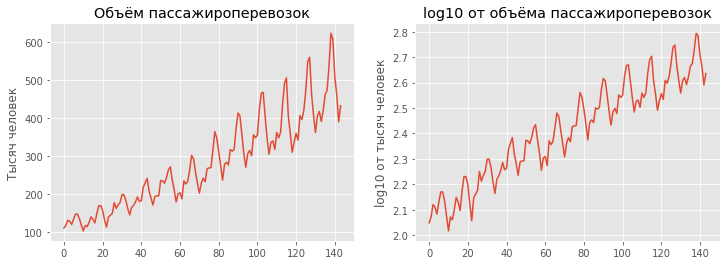

In [4]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
df['series_g'].plot(ax=ax1)
ax1.set_title(u'Объём пассажироперевозок')
ax1.set_ylabel(u'Тысяч человек')

ax2 = fig.add_subplot(122)
pd.Series(np.log10(df['series_g'])).plot(ax=ax2)
ax2.set_title(u'log10 от объёма пассажироперевозок')
ax2.set_ylabel(u'log10 от тысяч человек')

Вывод: будем строить модель линейной регрессии для приближения логарифма от объёма перевозок. То есть
$$\log y_i = \beta x_i + c(x_i) + \varepsilon_i,$$
где $y_i$ -- объём перевозок, $x_i$ -- порядковый номер месяца, $c(x_i)$ -- сезонная составляющая, $\varepsilon_i$ -- случайный шум.

Для удобства дальнейшего использования создадим дополнительно 12 новых месяцев для построения прогноза на них. Для этого создадим эти 12 новых дат с помощью функции ```pd.date_range```. Данный объект будет объектом класса ```DateTimeIndex``` (наследованный от класса ```Index```), и чтобы объединить их с колонкой ```df['date']```, принадлежащей классу ```datetime64```, придётся привести последнюю к классу ```Index```. Объединим два набора дат и сохраним их в объекте ```new_dates```.

Далее создадим фиктивный датафрейм ```df2```, состоящий из одной колонки с этими новыми датами, и приклеим его к исходному датафрейму ```df``` с помозью функции ```pd.merge```. Эта функция склеивает два датасета по указанному набору колонок (параметр ```on```) и по указанному правилу склейки (параметр ```how```). В ```on``` указываем одну общую колонку ```date```, по которой нужно произвести склейку. В ```how``` указываем ```right```, что означает следующее: 
возьми весь правый датасет и приклей к нему левый датасет по условию совпадения значений колонки ```on```, а в случае если для значений из правой колонки ```on``` не найдётся соотвествующих значений в левой колонке ```on```, то тогда приклей ```NaN``` значения. Вообще говоря, опция ```how``` соответствует опциям ```JOIN``` в языке SQL (```LEFT JOIN```, ```RIGHT_JOIN```, ```INNER JOIN```, ```OUTER_JOIN```).

In [6]:
# Создаём последовательсть месяцев. freq='MS' означает первое число каждого месяца из указанного диапазона дат
new_dates = pd.date_range('1961-01-01', '1961-12-01', freq='MS')
# Приводим df['date'] к типу Index, объединяем с 12 месяцами, полученными на предыдущем шаге
new_dates = pd.Index(df['date']) | new_dates
# Создаём датафрейм из одной колонки с расширенным набором дат
df2 = pd.DataFrame({'date': new_dates})
# Объединяем два датафрейма по колонке 'date'.
df = pd.merge(df, df2, on='date', how='right')
df.tail()

<ipython-input-6-a00b375a40bd>:4: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  new_dates = pd.Index(df['date']) | new_dates


,date,series_g
151,1961-08-01,NaN
152,1961-09-01,NaN
153,1961-10-01,NaN
154,1961-11-01,NaN
155,1961-12-01,NaN


Создадим регрессионную переменную ```month_num``` -- порядковый номер пары (месяц, год).Это необходимо для математических преобразований, т.к. с датами работать неудобно. И прологарифмируем таргет.

In [7]:
df['month_num'] = range(1, len(df) + 1)
df['log_y'] = np.log10(df['series_g'])
df.tail()

,date,series_g,month_num,log_y
151,1961-08-01,NaN,152,NaN
152,1961-09-01,NaN,153,NaN
153,1961-10-01,NaN,154,NaN
154,1961-11-01,NaN,155,NaN
155,1961-12-01,NaN,156,NaN


Создадим 12 колонок ```season_1```, ```season_2```, ..., ```season_12```, в которые поместим индикаторы соответствующего месяца. Чтобы достать порядковый номер месяца в каждой строчке, применим последовательно пару методов ```dt``` и ```month``` к колонке ```df['date']```. Внутри цикла будем проверять, равен ли очередной месяц текущему значению из цикла. Таким образом, каждая колонка заполнится так, что для соответствующего месяца в ней будут единицы, а для остальных месяцев - нули.

In [8]:
for x in range(1, 13):
    df['season_' + str(x)] = df['date'].dt.month == x
df.head()

,date,series_g,month_num,log_y,season_1,season_2,season_3,season_4,season_5,season_6,season_7,season_8,season_9,season_10,season_11,season_12
0,1949-01-01,112.0,1,2.049218,True,False,False,False,False,False,False,False,False,False,False,False
1,1949-02-01,118.0,2,2.071882,False,True,False,False,False,False,False,False,False,False,False,False
2,1949-03-01,132.0,3,2.120574,False,False,True,False,False,False,False,False,False,False,False,False
3,1949-04-01,129.0,4,2.110590,False,False,False,True,False,False,False,False,False,False,False,False
4,1949-05-01,121.0,5,2.082785,False,False,False,False,True,False,False,False,False,False,False,False


Созданные ранее колонки являются линейно зависимыми с колонкой при свободном члене, т.к. "данные" при свободном члене всегда равны 1, а если сложить все образованные ранее колонки, то получится тоже самое. Для устранения линейной зависимости между колонками необходимо перейти не к абсолютным поправкам, а к относительным, т.е. выбрать какой-то столбец и вычесть его из всех остальных. Тогда поправки будут отражать сезонные изменения **относительно выбранного столбца**. Пусть базовым месяцем будет январь.

In [9]:
# range(2, 13) соответствует всем месяцам с февраля по декабрь
season_columns = ['season_' + str(x) for x in range(2, 13)]

# Создадим объекты матрицу X и вектор y для обучения модели
X = df[['month_num'] + season_columns]
y = df['log_y']

# Оставим только те строчки, у которых известны значения y (с номером < 144)
X1 = X[X.index < 144]
y1 = y[y.index < 144]
X.head()

,month_num,season_2,season_3,season_4,season_5,season_6,season_7,season_8,season_9,season_10,season_11,season_12
0,1,False,False,False,False,False,False,False,False,False,False,False
1,2,True,False,False,False,False,False,False,False,False,False,False
2,3,False,True,False,False,False,False,False,False,False,False,False
3,4,False,False,True,False,False,False,False,False,False,False,False
4,5,False,False,False,True,False,False,False,False,False,False,False


Настраиваем линейную регрессионную модель.

In [9]:
model = LinearRegression()
model.fit(X1, y1)

LinearRegression()

Построим нашу модель вместе с реальными данными, чтобы визуально оценить ее качество.

<AxesSubplot:>

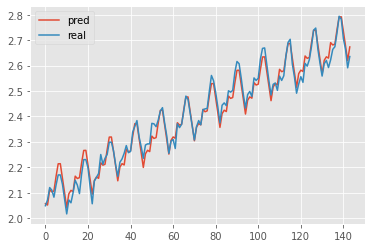

In [10]:
pred = pd.DataFrame({
    'pred': model.predict(X1),
    'real': y1})
pred.plot()

Теперь построим предсказание для всей матрицы ```X```, включая неизвестные 12 месяцев.

<AxesSubplot:>

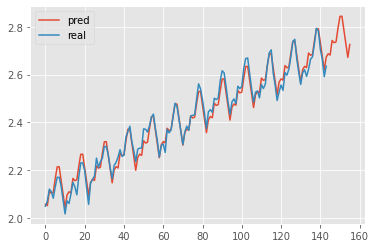

In [11]:
pred = pd.DataFrame({
    'pred': model.predict(X),
    'real': y})
pred.plot()

Выведем численные значения предсказанной переменной y на следующие 12 месяцев.

In [12]:
print(pred['pred'][144:])

144    2.686874
145    2.681669
146    2.742599
147    2.733392
148    2.736734
149    2.794154
150    2.843669
151    2.844005
152    2.785564
153    2.729935
154    2.671892
155    2.725716
Name: pred, dtype: float64


# Лекция №9.5. Кросс-валидация и kNN (k-Nearest Neighbours, k-ближайших соседей).

*Примечание*: Этих материалов не было в курсе 2018 года, на основе которого остальная часть конспектов. Это раздел из курса 2021 года: https://www.youtube.com/playlist?list=PL5OwdzVJ1GaYjMu2JsHDwbY-NTRCVZxGs. Отсюда и странная нумерация лекции.

### Кросс-валидация

Смысл кросс-валидации состоит в уменьшении влияния данного конкретного разбиения выборки на обучающую и тестовую (или валидационную) на результат работы классификатора (например, его точность).

*В идеальном случае*: разбиваем изначальную выборку на обучающую и тестовую (либо изначально имеем две отдельные выборки). Тестовая выборка используется **только** для проверки **конечного** варианта классификатора. Обучающая выборка разбивается случайным образом на k-частей, называемых folds (k-fold cross-validation). Затем k раз производится обучение классификатора, каждый раз в качестве валидационной используется новая выборка из folds, а остальные вместе - как обучающая. После этого получаем k обученных классификаторов, результаты работы которых учитывают при итоговом ответе (например, усредняют для регрессии или берут максимум для классификации). Только после этого финальный усредненный классификатор проверяется на заранее отложенной тестовой выборке.

### Метод k-ближайших соседей

*Определение для задачи классификации*: **Метод k-ближайших соседей** - классификатор, который каждое новое значение относит к тому классу, к которому принадлежит большинство из k ближайших к данной новой точке (согласно выбранной метрике расстояния) значений.

*Определение для задачи регрессии*: **Метод k-ближайших соседей** - классификатор, который каждому новому значению присваивает среднее, рассчитанное по k ближайших к данной новой точке (согласно выбранной метрике расстояния) значений.

Иллюстрация: при k=3 новая точка (кружок) будет классифицирована как треугольник, а при k=5 - как квадрат.
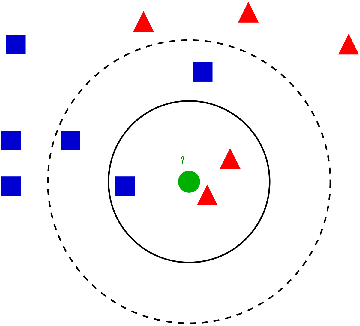

**Достоинства**:  
+ Метод k-ближайших соседей является **состоятельным**. **Состоятельный метод** - метод, точность которого стремится к точности байесовского классификатора при числе наблюдений, стремящемся к бесконечности. Байесовский классификатор имеет максимальную точность (accuracy), но только тогда, когда известно совместное распределение предикторов и отклика (что на практике не бывает почти никогда).
+ Легко добавить в классификатор новое наблюдение.

**Недостатки**:  
- Малоинформативные переменные и шум очень сильно влияют на результат классификации. Т.е. требуется более подробный и тщательный предварительный анализ данных. Также необходимо стандартизировать переменные;
- Большой объем вычислений;
- Чувствительность к несбалансированности объемов классов.

Если среди k-соседей невозможно однозначно определить доминирующий класс (классы разделились на равные части), то для конкретной данной новой точки количество соседей, по которым определяют класс, увеличивается.

Результат работы классификатора можно интерпретировать как вероятность принадлежать классу m, если кол-во элементов, принадлежащих классу m разделить на k: $p_m$ = $n_m$/k. 

На практике применяют модификацию метода, в которой при выборе большинства/подсчете среднего классы соседей учитываются с весовыми коэффициентами, обратно пропорциональными расстоянию до новой классифицируемой точки.

**Гиперпараметры**:  
* k - число ближайших соседей;  
* метод вычисления расстояния.

### Пример №1

In [13]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [14]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [15]:
df = pd.read_csv('Wine.txt', sep='\t')
df.head()

,Input1,Input2,Input3,Input4,Input5,Input6,Input7,Input8,Input9,Input10,Input11,Input12,Input13,Desired1(3)
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,0
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,0


Разделяем предикторы и отклик

In [16]:
X = df.iloc[:,:-1].values
y = df.iloc[:,13].values

Применяем разбиение на folds для кросс-валидации:  
* n_splits - кол-во folds;  
* shuffle - перемешивать ли данные при разбиении на folds или брать подряд.

In [17]:
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=19)

In [18]:
# Варианты значений числа соседей
search_space = [i for i in range(1,16)]

Подготовим вектор для хранения результатов подсчета accuracy заранее, т.к. append является неэффективным.

In [19]:
accuracies = np.full((n_folds, len(search_space)), -9999.0)

In [20]:
fold_num = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    j_count = 0
    for j in search_space:
        knn_res = KNeighborsClassifier(n_neighbors=j)
        knn_res.fit(X_train, y_train)
        predictions = knn_res.predict(X_test)
        accuracies[fold_num, j_count] = np.mean(predictions == y_test)
        
        j_count += 1
    fold_num += 1

print(accuracies)

[[0.88888889 0.83333333 0.91666667 0.86111111 0.88888889 0.83333333
  0.91666667 0.91666667 0.91666667 0.91666667 0.91666667 0.91666667
  0.94444444 0.91666667 0.91666667]
 [0.91666667 0.91666667 0.91666667 0.91666667 0.94444444 0.94444444
  0.94444444 0.94444444 1.         0.94444444 1.         0.94444444
  0.97222222 1.         1.        ]
 [0.97222222 0.97222222 0.97222222 0.91666667 0.94444444 0.91666667
  0.91666667 0.91666667 0.94444444 0.91666667 0.94444444 0.91666667
  0.94444444 0.94444444 0.94444444]
 [0.94285714 0.94285714 1.         1.         1.         0.97142857
  1.         0.97142857 1.         1.         1.         1.
  1.         0.97142857 0.97142857]
 [0.97142857 0.91428571 0.91428571 0.88571429 0.97142857 0.91428571
  0.97142857 0.94285714 1.         0.97142857 0.97142857 0.91428571
  0.97142857 0.94285714 1.        ]]


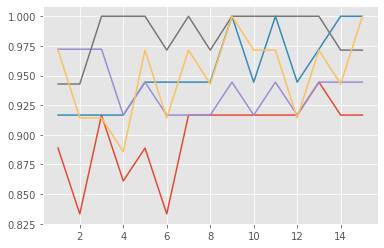

In [21]:
for i in range(len(accuracies)):
    plt.plot(list(range(1, 16)), accuracies[i, :])

Определим наилучшее кол-во соседей

In [22]:
avr_acc = np.average(accuracies, axis=0)
max_avr_acc = max(avr_acc)
kNN_best = np.argmax(avr_acc)+1
print('Максимальное значение усредненной по всем folds точности {0} достигнуто при кол-ве соседей kNN_best = {1}.'.format(max_avr_acc, kNN_best))

Максимальное значение усредненной по всем folds точности 0.9722222222222221 достигнуто при кол-ве соседей kNN_best = 9.


### Пример №2.

Используем стандартную библиотеку для применения кросс-валидации

In [10]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

In [12]:
df = pd.read_csv('Wine.txt', sep='\t')
df.head()

,Input1,Input2,Input3,Input4,Input5,Input6,Input7,Input8,Input9,Input10,Input11,Input12,Input13,Desired1(3)
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,0
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,0


In [13]:
X = df.iloc[:,:-1].values
y = df.iloc[:,13].values

In [14]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [15]:
n_folds = 5
k_max = 15
k_scores = []

for k in range(1, k_max+1):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=n_folds, scoring='accuracy')
    k_scores.append(scores.mean())

In [16]:
k_scores

[0.9495238095238095,
 0.9328571428571429,
 0.943968253968254,
 0.9384126984126985,
 0.9550793650793651,
 0.943968253968254,
 0.9665079365079364,
 0.9609523809523809,
 0.9496825396825397,
 0.9552380952380952,
 0.9496825396825397,
 0.9496825396825397,
 0.9496825396825397,
 0.9552380952380952,
 0.9607936507936508]

In [18]:
max_avr_acc = max(k_scores)
kNN_best = np.argmax(k_scores)+1
print('Максимальное значение усредненной по всем folds точности {0} достигнуто при кол-ве соседей kNN_best = {1}.'.format(max_avr_acc, kNN_best))

Максимальное значение усредненной по всем folds точности 0.9665079365079364 достигнуто при кол-ве соседей kNN_best = 7.
